In [1]:
import pandas as pd
import numpy as np

from datasets import Dataset

In [2]:
fx = pd.read_csv(
    'data/EURUSD_1min.txt',
    names = ['day', 'time', 'open',
            'high', 'low', 'close', 'volume'])

fx['datetime'] = fx['day'].astype(str) + " " + fx['time']
fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)

fx = fx.drop(columns = ['day', 'time'])

# Preprocessing

- Step 1: linearly interpolate gaps (shoot, not sure how to do this in parallel besides filling in all gaps and then getting rid of friday -> sunday
- Step 2: so we will go from 21:00 to 21:00 from sunday to friday
    - make a "trading day" feature starting from 21:00 of 
    - get rid of stragler days with no trades at end and beginning if the don't match up right
- Step 3: subtract the day's open at 21:00 from each day (group by day easy) -- let's not honestly...
- Step 4: make relative volume indicator using comparing real volume to groupby day's MA -- yeah I mean for now let's not
- Step 5: 60min HLC

- Step 6: create train, validation and test datasets
- Step 7: divide each column by their std (ungrouped) USING ONLY TRAINING SET MAKING SURE TO SAVE THIS NUMBER -- not for now


Make JSON:
- make the weekday and relative volume a feature
- make inputs_embeds a 2d array containing OHLCV and label 2D array of HLC (no day of week)
- store as JSON

In [3]:
# Linearly interpolate time gaps
fx = fx.set_index('datetime').asfreq('1min')
fx['close'] = fx['close'].fillna(method = 'ffill')
fx['volume'] = fx['volume'].fillna(0) # no volume in gaps (according to first rate data people)

# fill open high and low with most recent close
fx = fx.fillna({
    'open': fx['close'],
    'high': fx['close'],
    'low': fx['close']
})

In [4]:
# define the "trading day" as from starting on 9pm UTC of the previous day ending at 8:59pm UTC
fx['day'] = fx.index.dayofweek 
fx.loc[fx.between_time('21:00', '23:59').index, 'day'] += 1
fx['day'] = fx['day'] % 7 # sunday = 6, then + 1 would be 7 but we want that roll over to monday = 0

# ordinal trading day since start of data (just for help in preprocessing)
fx['ordinal_day'] = (fx['day'] != fx['day'].shift()).cumsum()

<AxesSubplot:>

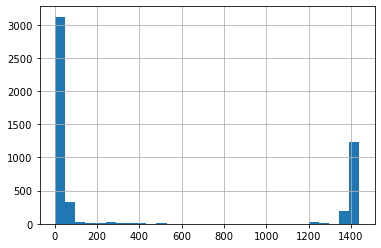

In [5]:
# look at distribution of how many 0 volume minute
(fx['volume'] == 0.).groupby(fx['ordinal_day']).sum().hist(bins = 30)

In [6]:
# let's just arbitrary say there should be less than 100 zero volume -- shouldn't really mattter in the end
voluminous_index = (fx['volume'] == 0.).groupby(fx['ordinal_day']).filter(lambda x: x.sum() < 100).index
fx = fx.loc[voluminous_index]

In [7]:
# quick sanity check of data 
fx.between_time('20:59', '21:01')

,open,high,low,close,volume,day,ordinal_day
datetime,,,,,,,
2009-01-02 20:59:00,1.38480,1.38520,1.38470,1.38510,61.0,4,1
2009-01-04 21:00:00,1.38980,1.38980,1.38980,1.38980,3.0,0,4
2009-01-04 21:01:00,1.38980,1.38980,1.38930,1.38960,8.0,0,4
2009-01-05 20:59:00,1.35720,1.35730,1.35710,1.35730,36.0,0,4
2009-01-05 21:00:00,1.35730,1.35760,1.35710,1.35760,96.0,1,5
...,...,...,...,...,...,...,...
2022-09-29 21:00:00,0.98130,0.98180,0.98130,0.98160,32.0,4,5020
2022-09-29 21:01:00,0.98163,0.98180,0.98145,0.98148,21.0,4,5020
2022-09-30 20:59:00,0.98019,0.98068,0.97970,0.98000,40.0,4,5020


# All data

In [1]:
import os
import pandas as pd
import numpy as np

from datasets import Dataset, concatenate_datasets

In [2]:
def make_dataset(filename, periods = 60):
    fx = pd.read_csv(
    filename,
    names = ['day', 'time', 'open',
            'high', 'low', 'close', 'volume'])

    fx['datetime'] = fx['day'].astype(str) + " " + fx['time']
    fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)

    fx = fx.drop(columns = ['day', 'time'])
    
    # Linearly interpolate time gaps
    fx = fx.set_index('datetime').asfreq('1min')
    fx['close'] = fx['close'].fillna(method = 'ffill')
    fx['volume'] = fx['volume'].fillna(0) # no volume in gaps (according to first rate data people)

    # fill open high and low with most recent close
    fx = fx.fillna({
        'open': fx['close'],
        'high': fx['close'],
        'low': fx['close']
    })
    
    # define the "trading day" as from starting on 9pm UTC of the previous day ending at 8:59pm UTC
    fx['day'] = fx.index.dayofweek 
    fx.loc[fx.between_time('21:00', '23:59').index, 'day'] += 1
    fx['day'] = fx['day'] % 7 # sunday = 6, then + 1 would be 7 but we want that roll over to monday = 0

    # ordinal trading day since start of data (just for help in preprocessing)
    fx['ordinal_day'] = (fx['day'] != fx['day'].shift()).cumsum()
    
    # let's just arbitrary say there should be less than 100 zero volume -- shouldn't really mattter in the end
    voluminous_index = (fx['volume'] == 0.).groupby(fx['ordinal_day']).filter(lambda x: x.sum() < 100).index
    fx = fx.loc[voluminous_index]

    futures = {}
    for i in range(1, periods + 1):
        col_name = f'future_close{i}'
        futures[col_name]  = fx['close'].shift(-i) - fx['close']
    futures_df = pd.DataFrame(futures)
    future_cols = futures_df.columns

    fx = pd.concat((fx, futures_df), axis = 1)
    
    # clean up data odditity of future columns coming from the future of non-consecutive days (i.e. no overnight trading)
    fx['day_break'] = ((fx['day'] != (fx['day']).shift(-1)) & (fx['day'] != (fx['day'] - 1).shift(-1)))
    no_futures = fx[fx.groupby('ordinal_day')['day_break'].transform('any')].between_time(f'{20 - periods // 60}:{59 - periods % 60}', '20:59').index
    fx.loc[no_futures, future_cols] = 0
    
    # de mean using opening price of day
    fx['day_close'] = fx['close'].sub(fx.groupby('ordinal_day')['close'].transform('first'), axis = 0)
    fx[['open', 'high', 'low']] = fx[['open', 'high', 'low']].sub(fx['close'], axis = 0)
    fx['close'] = fx['close'] - fx['close'].shift(1)
    
#     # de mean volume using rolling average of day
#     fx["volume"] = fx['volume'] - fx['volume'].groupby(fx['ordinal_day']).rolling(5000, min_periods = 0).mean().reset_index(drop = True, level = 0)
    
    # get rid of first and last day due to data incompleteness
    fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].min()].index)
    fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].max()].index)
    
    features = ['open', 'high', 'low', 'close', 'day_close']
    
    stds = fx.iloc[:4000000][features].std(axis = 0)
    fx[features] = fx[features].div(stds, axis = 1)
    
    print(filename, '\n', repr(stds.values))
    
    ohlcv = fx[features].values.reshape(-1, 1440, 5)
    future = fx[future_cols].values.reshape(-1, 1440, periods)
    
    # save some memory
    del fx
    
    ds = Dataset.from_dict({"ohlcv": ohlcv, "future": future})
    
    return ds

In [3]:
data_dir = './data/1mins/'
os.listdir(data_dir)

['AUDUSD_1min.txt',
 'EURCHF_1min.txt',
 'EURGBP_1min.txt',
 'EURJPY_1min.txt',
 'EURUSD_1min.txt',
 'GBPJPY_1min.txt',
 'GBPUSD_1min.txt',
 'USDCAD_1min.txt',
 'USDCHF_1min.txt',
 'USDJPY_1min.txt']

In [4]:
# make eurusd the last dataset
filenames = [
    'AUDUSD_1min.txt',
    'EURCHF_1min.txt',
    'EURGBP_1min.txt',
    'EURJPY_1min.txt',
    'GBPJPY_1min.txt',
    'GBPUSD_1min.txt',
    'USDCAD_1min.txt',
    'USDCHF_1min.txt',
    'USDJPY_1min.txt',
    'EURUSD_1min.txt'
]

In [5]:
all_datasets = Dataset.from_dict({"ohlcv": [], "future": []}) # just an initialization

for file in filenames:
    dataset = make_dataset(data_dir + file)
#     if file != "EURUSD_1min.txt":
#         # need to cut off last few days to allow for "forward testing"
#         split = dataset.train_test_split(.05, shuffle = False, keep_in_memory = True)
#         dataset = split['train']
    
    all_datasets = concatenate_datasets((all_datasets, dataset))
#     print(file, end = '\r')

./data/1mins/AUDUSD_1min.txt 
 array([0.00017544, 0.0001289 , 0.00012869, 0.00020141, 0.00420767])
./data/1mins/EURCHF_1min.txt 
 array([0.00015943, 0.00012811, 0.00012887, 0.00020714, 0.00346342])
./data/1mins/EURGBP_1min.txt 
 array([0.00013495, 0.00010049, 0.00010396, 0.00015599, 0.00306316])
./data/1mins/EURJPY_1min.txt 
 array([0.02540015, 0.01861955, 0.01853017, 0.02725528, 0.60491368])
./data/1mins/GBPJPY_1min.txt 
 array([0.0333769 , 0.02473986, 0.0244145 , 0.03538734, 0.82613484])
./data/1mins/GBPUSD_1min.txt 
 array([0.00024653, 0.00018456, 0.00018529, 0.00027917, 0.00578123])
./data/1mins/USDCAD_1min.txt 
 array([0.00017359, 0.00012897, 0.00013408, 0.00024119, 0.00374798])
./data/1mins/USDCHF_1min.txt 
 array([0.00017272, 0.00013109, 0.00013035, 0.00022164, 0.00414723])
./data/1mins/USDJPY_1min.txt 
 array([0.01694065, 0.01276201, 0.01261803, 0.01969121, 0.40558088])
./data/1mins/EURUSD_1min.txt 
 array([0.00020527, 0.00015178, 0.00015272, 0.00022341, 0.00463119])


In [8]:
all_datasets

Dataset({
    features: ['ohlcv', 'future'],
    num_rows: 34429
})

In [7]:
all_datasets.save_to_disk("data/fx_days.ds")

In [5]:
ds.save_to_disk("data/new_eur.ds")